In [1]:
import magpylib as magpy
import numpy as np
import matplotlib.pyplot as plt


def method_1(radius, current):
    distance = radius  # distance between the centers of the loops

    # Create the two circular loops
    loop1 = magpy.current.Circle(current=+current, diameter=2*radius)
    loop2 = magpy.current.Circle(current=-current, diameter=2*radius)

    # Position the loops at +distance/2 and -distance/2 along the z-axis
    loop1.move([0, 0, distance/2])
    loop2.move([0, 0, -distance/2])

    # Create a collection of the two loops
    collection = magpy.Collection(loop1, loop2)
    collection.show()

    return collection

# Define parameters
radius = 100e-3  # in mm
current = 200  # in A

anti_helmholtz = method_1(radius, current)


Text(0, 0.5, '$Gradient$ [mT/m]')

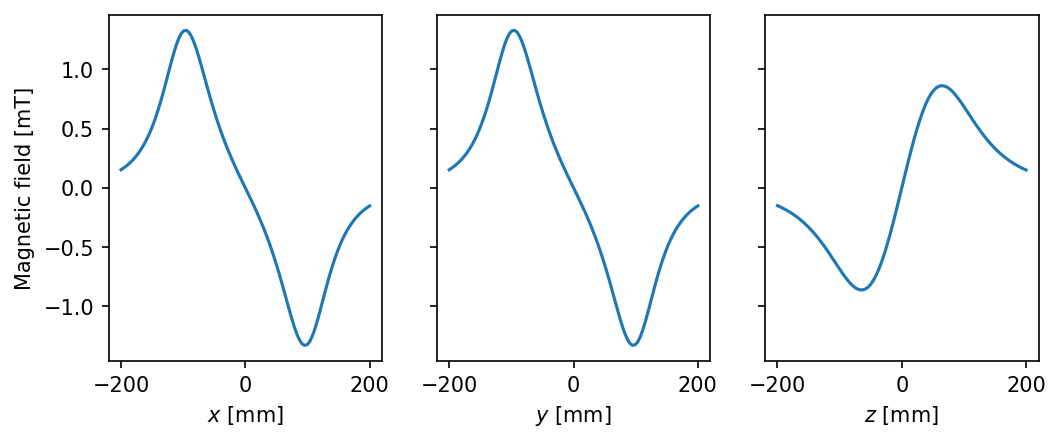

<Figure size 1200x900 with 0 Axes>

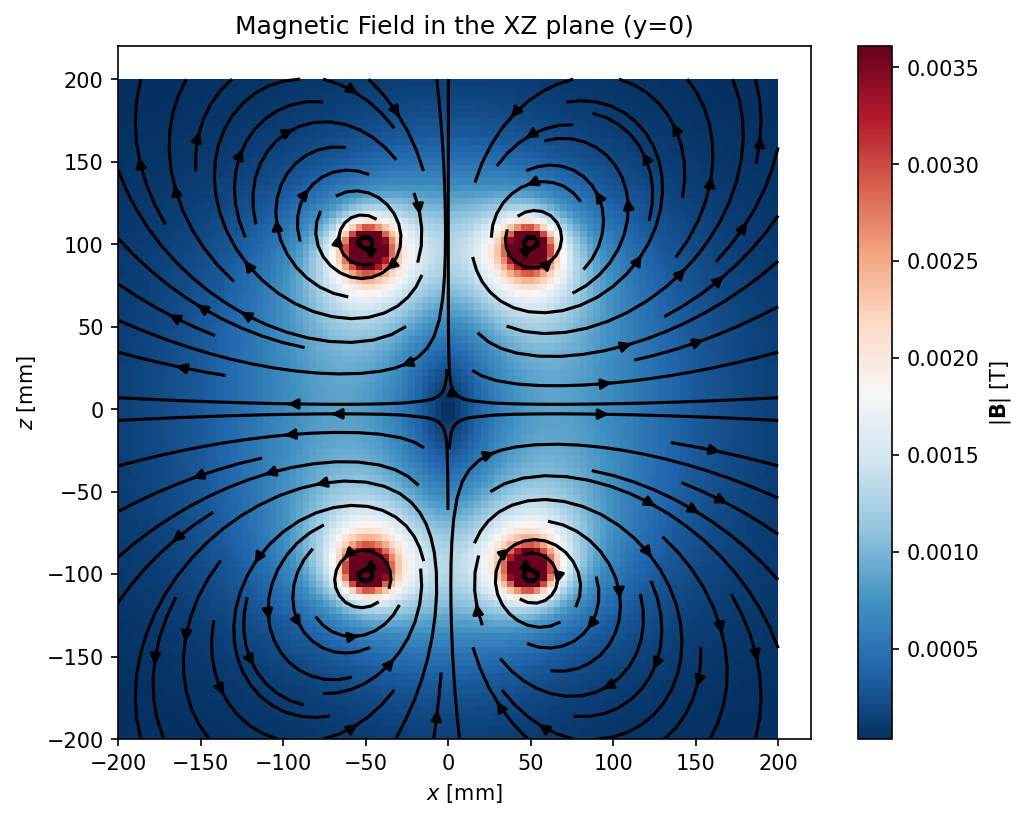

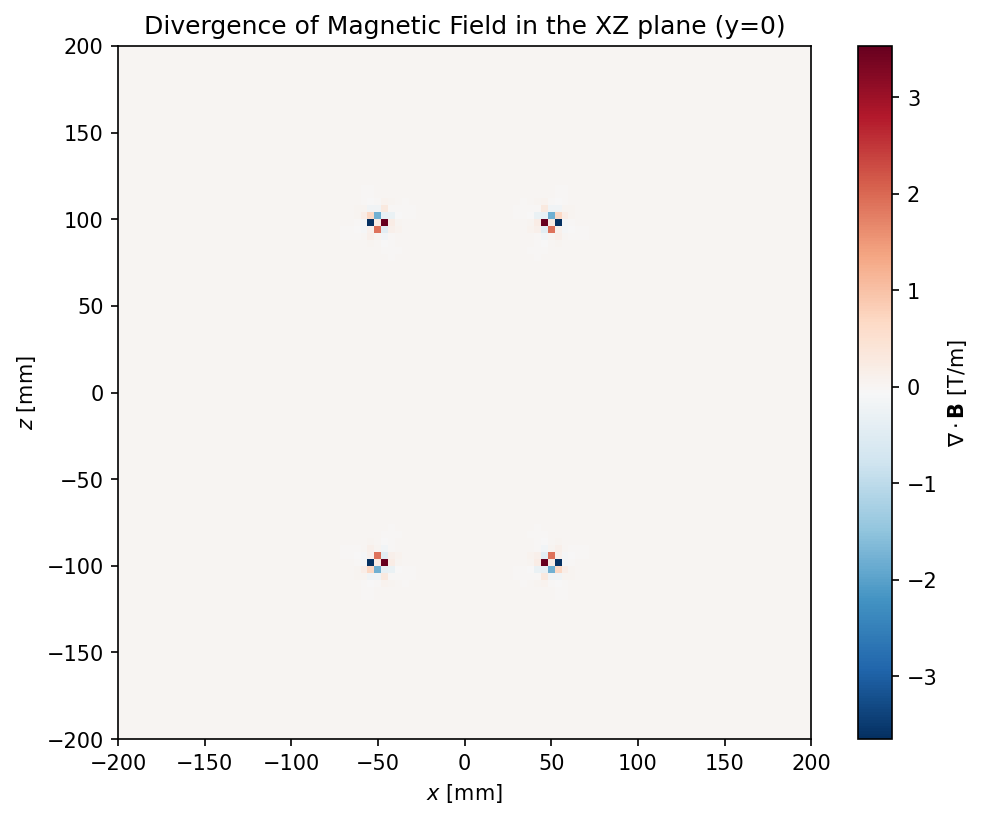

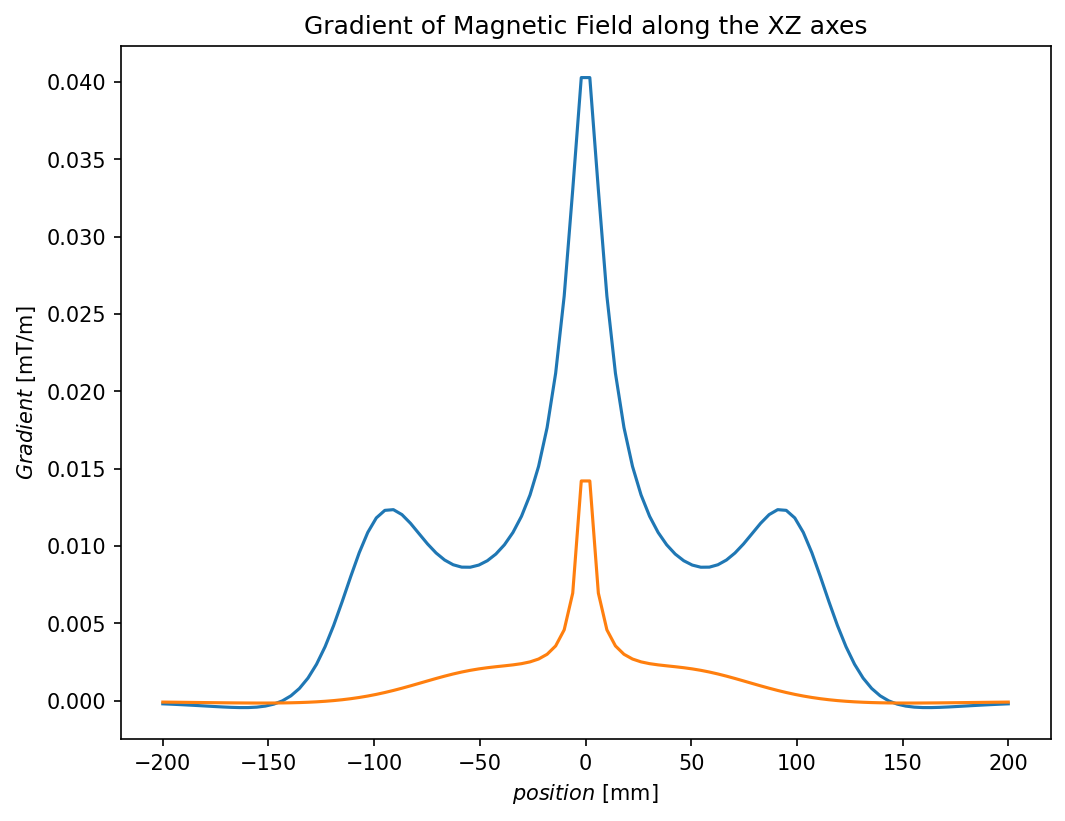

In [2]:

N = 100  # Increased grid resolution
r = np.linspace(-radius * 2, radius * 2, N)

# Define a 3D grid for calculation
mid = N//2 
dr = r[1]-r[0]

X_3D, Y_3D, Z_3D = np.meshgrid(r, r, r, indexing='ij')

# Flatten the grid for magpy.getB function
positions = np.vstack([X_3D.ravel(), Y_3D.ravel(), Z_3D.ravel()]).T

# Calculate the magnetic field components at each grid point
B = magpy.getB(anti_helmholtz, positions)

Bx = B[:, 0].reshape(N, N, N)
By = B[:, 1].reshape(N, N, N)
Bz = B[:, 2].reshape(N, N, N)

B = B.reshape((N, N, N, 3))
 
# Calculate the gradient
grad_Bx, grad_By, grad_Bz = np.gradient(Bx, dr, axis=0) , np.gradient(By, dr, axis=1) , np.gradient(Bz, dr, axis=2)

# Calculate the numerical divergence of the magnetic field
div_B = grad_Bx +  grad_By +  grad_Bz 

# Magnetic field in the center
f, axs = plt.subplots(1,3, sharey=True, dpi=150,figsize=(8, 3))
axs[0].plot(r*1e3, Bx[:,mid,mid]*1e3)
axs[1].plot(r*1e3, By[mid,:,mid]*1e3)
axs[2].plot(r*1e3, Bz[mid,mid,:]*1e3)
axs[0].set_xlabel('$x$ [mm]')
axs[1].set_xlabel('$y$ [mm]')
axs[2].set_xlabel('$z$ [mm]')
axs[0].set_ylabel('Magnetic field [mT]')

# Plot magnetic field
plt.figure(figsize=(8, 6), dpi=150)
X_2D, Z_2D = np.meshgrid(r, r, indexing='ij')

# Calculate the magnitude of the magnetic field in the XZ plane at Y=0 (midplane)
B_magnitude = np.sqrt(Bx[:, mid, :]**2 + By[:, mid, :]**2 + Bz[:, mid, :]**2)

# Clip the magnitude to a maximum value to avoid saturation
max_magnitude = np.percentile(B_magnitude, 99)  # Clipping at the 99th percentile
B_magnitude_clipped = np.clip(B_magnitude, None, max_magnitude)

B_grad_XZ_z = np.gradient(B_magnitude, axis=1)
B_grad_XZ_x = np.gradient(B_magnitude, axis=0)
B_grad_XY_mag = np.sqrt(B_grad_XZ_z**2 +B_grad_XZ_x**2 )
# Plot the magnitude of the magnetic field using imshow
img_borders = (r.min()*1e3, r.max()*1e3, r.min()*1e3, r.max()*1e3)
plt.figure(figsize=(8, 6), dpi=150)
plt.imshow(B_magnitude_clipped, extent=img_borders, origin='lower', cmap='RdBu_r')
plt.colorbar(label=r'$|\mathbf{B}|$ [T]')
plt.streamplot(Z_2D*1e3, X_2D*1e3,  Bz[:,mid,:],  Bx[:,mid,:], color="black", density=1 )
plt.title('Magnetic Field in the XZ plane (y=0)')
plt.xlabel('$x$ [mm]')
plt.ylabel('$z$ [mm]')
plt.gca().set_aspect("equal")

# Plot the divergence
plt.figure(figsize=(8, 6), dpi=150)
plt.imshow(div_B[:, mid, :], extent=img_borders, origin='lower', cmap='RdBu_r')
plt.colorbar(label='$\\nabla \\cdot \\mathbf{B}$ [T/m]')
plt.title('Divergence of Magnetic Field in the XZ plane (y=0)')
plt.xlabel('$x$ [mm]')
plt.ylabel('$z$ [mm]');

# Plot the gradient
plt.figure(figsize=(8, 6), dpi=150)
plt.title('Gradient of Magnetic Field along the XZ axes')
# plt.imshow(B_grad_XY_mag, extent=img_borders, origin='lower', cmap='RdBu_r')

plt.plot(r*1e3, B_grad_XZ_z[:,mid]*1e3)
plt.plot(r*1e3, B_grad_XZ_x[mid,:]*1e3)
plt.xlabel('$position$ [mm]')
plt.ylabel('$Gradient$ [mT/m]')
